# MS2DeepScore API – Quickstart

*In order to use omigami, you need an access token provided by DataRevenue.*
## Introduction

This is a short guide on how you can add GNPS library matches to your mass spectra by their Tanimoto Score - using Omigami's MS2DeepScore API.

The API uses a MS2DeepScore model which was trained on > 100,000 MS/MS spectra from GNPS. It prepares the input spectra and using a Siamese neural network predicts the molecular structural similarity (Tanimoto score) of the input spectra with the GNPS library spectra. It then returns you the top library matches for each of your spectra.

This notebook shows you how to:
1. Specify any MGF file with two spectra.
2. Run a library search through the MS2DeepScore API
3. Save the results as XLSX.

# 1. Load a MS/MS dataset (MGF format)

We'll use a small MS/MS dataset in the MGF format from [here](https://gnps-external.ucsd.edu/gnpslibrary/GNPS-COLLECTIONS-MISC.mgf).
You can also select any other from the [GNPS spectral library](https://gnps-external.ucsd.edu/gnpslibrary), or - of course - use your own.

*Note that you will need the Precursor_MZ field `PEPMASS` and the abundance pairs in your MGF file.*

In [1]:
# Load your own MS/MS dataset
path_to_mgf = 'GNPS-2-SPECTRA.mgf'

In [ ]:
# OR download a small MS/MS dataset from GNPS, in the same directory as this notebook
import urllib.request

url = 'https://gnps-external.ucsd.edu/gnpslibrary/GNPS-COLLECTIONS-MISC.mgf'

path_to_mgf = f'GNPS-COLLECTIONS-MISC.mgf' # use your prefered saving path here

urllib.request.urlretrieve(url, path_to_mgf)

# 2. Query for the best matches with MS2DeepScore

`MS2DeepScore` is a python wrapper which:
- Builds a json payload from the MGF file
- Calls the MS2DeepScores API
- Formats the prediction results into readable dataframes

____
`match_spectra_from_path()` takes the following arguments:
- `n_best` sets the number of matches you'd like per spectrum (it is set to 10 by default).
- `include_metadata` selects the metadata fields that will be displayed in the resulting top matches.
- `ion_mode` selects the ionization mode of the measured spectra (positive or negative)

In the results dataframes, the input spectra can be identified by their number in the dataframes index, which refers to their order in the MGF file.  
*i.e.* `matches of spectrum 1` gives the spectrum_id and MS2DeepScore scores of the library spectra matches, for the first spectrum in the MGF file.

For each spectrum in the MGF file, the library spectra matches are sorted according to their MS2DeepScore similarity score (best is first).   
The following information about the predicted spectra are returned :
- `score`, the MS2DeepScore similarity score between the input spectrum and the library spectrum
- `matches of spectrum #`, the spectrum_ID of the matched library spectra for the spectrum number # in the MGF file
- `metadata`, metadata fields chosen with `include_metadata` in the input

In [2]:
from omigami import MS2DeepScore

In [3]:
# Initialize the client with your user token
ms2deepscore = MS2DeepScore(token="Valid Omigami Token")

In [4]:
# Run MS2DeepScore prediction
spectra_matches = ms2deepscore.match_spectra_from_path(
    path_to_mgf, 
    n_best=10, 
    ion_mode="positive",
    include_metadata=["smiles", "compound_name"]
)

## 2.1 View results
A list of dataframes is returned. To look at a specific dataframe you can call:
```python
ms2deepscore_matches[i]  # 'i' refers to the (i+1)th spectrum in the MGF file input
```

In [5]:
spectra_matches[1]

,score,compound_name,smiles
matches of spectrum-1,,,
CCMSLIB00005788085,0.939946,11559852 - putative Cembrane,CC1=CC(CC2=CC(C(C(CC(=CCC1)C)OC(=O)C)C(C)C)OC2...
CCMSLIB00005725129,0.803909,"4,7,7-trimethylbicyclo[2.2.1]heptan-2-yl (2E)-...",CC(C)(C1CC2)C2(C)CC1OC(/C=C/c(cc1)cc(OC)c1O)=O
CCMSLIB00005725495,0.698734,"5,7-dihydroxy-4-(1-hydroxypropyl)-6-(3-methylb...",CCC(C(c(c(O)c(CC=C(C)C)c(O)c1C(CC(C)C)=O)c1O1)...
CCMSLIB00005723760,0.652698,h_35_fluoxymesterone-m,OC1(C)CCC2C3CC(O)C4=CC(O)CCC4(C)C3(F)C(O)CC21C
CCMSLIB00000068226,0.627706,"""R-4-benzyl-3-((R)-3-hydroxy-2,2-dimethyloctan...",O=C1OC(C)(C)[C@@H](CC2=CC=CC=C2)N1C(C(C)(C)[C@...
CCMSLIB00005725381,0.622851,10-ethyl-14-methyl-3-(4-methyl-5-oxooxolan-2-y...,CCC(C(C(C1C)C2C3)OC1=O)C(CCCC1)C2N1C3C(CC1C)OC1=O
CCMSLIB00005489305,0.617251,hexamethylolmelamine pentamethyl ether (putative),COCN(C1=NC(N(COC)CO)=NC(N(COC)COC)=[N+]1[H])COC
CCMSLIB00005720293,0.60639,Riboflavin,CC1=CC2=C(C=C1C)N(C3=NC(=O)NC(=O)C3=N2)CC(C(C(...
CCMSLIB00005725339,0.523664,"methyl (1R,14R,15S)-15-ethyl-17-methyl-12-oxo-...",CC[C@@H](CN(C)[C@H]1Cc2c(C(C3)=O)[nH]c4c2cccc4...


# 3. Save results

Execute the following cell to save the results in an Excel file. For readability, each dataframe is saved in its own csv file under the matches directory.

In [6]:
import os
os.makedirs("matches", exist_ok=True)
for i, spectrum_matches in enumerate(spectra_matches):
    spectrum_matches.to_csv(f"matches/spectrum_{i}.csv")

# 4. Create Plots

The following cell will show you an example of how to visualize your matches.

In [7]:
from omigami import MoleculePlotter
plotter = MoleculePlotter()

### Creating a Plot of the molecular structure 

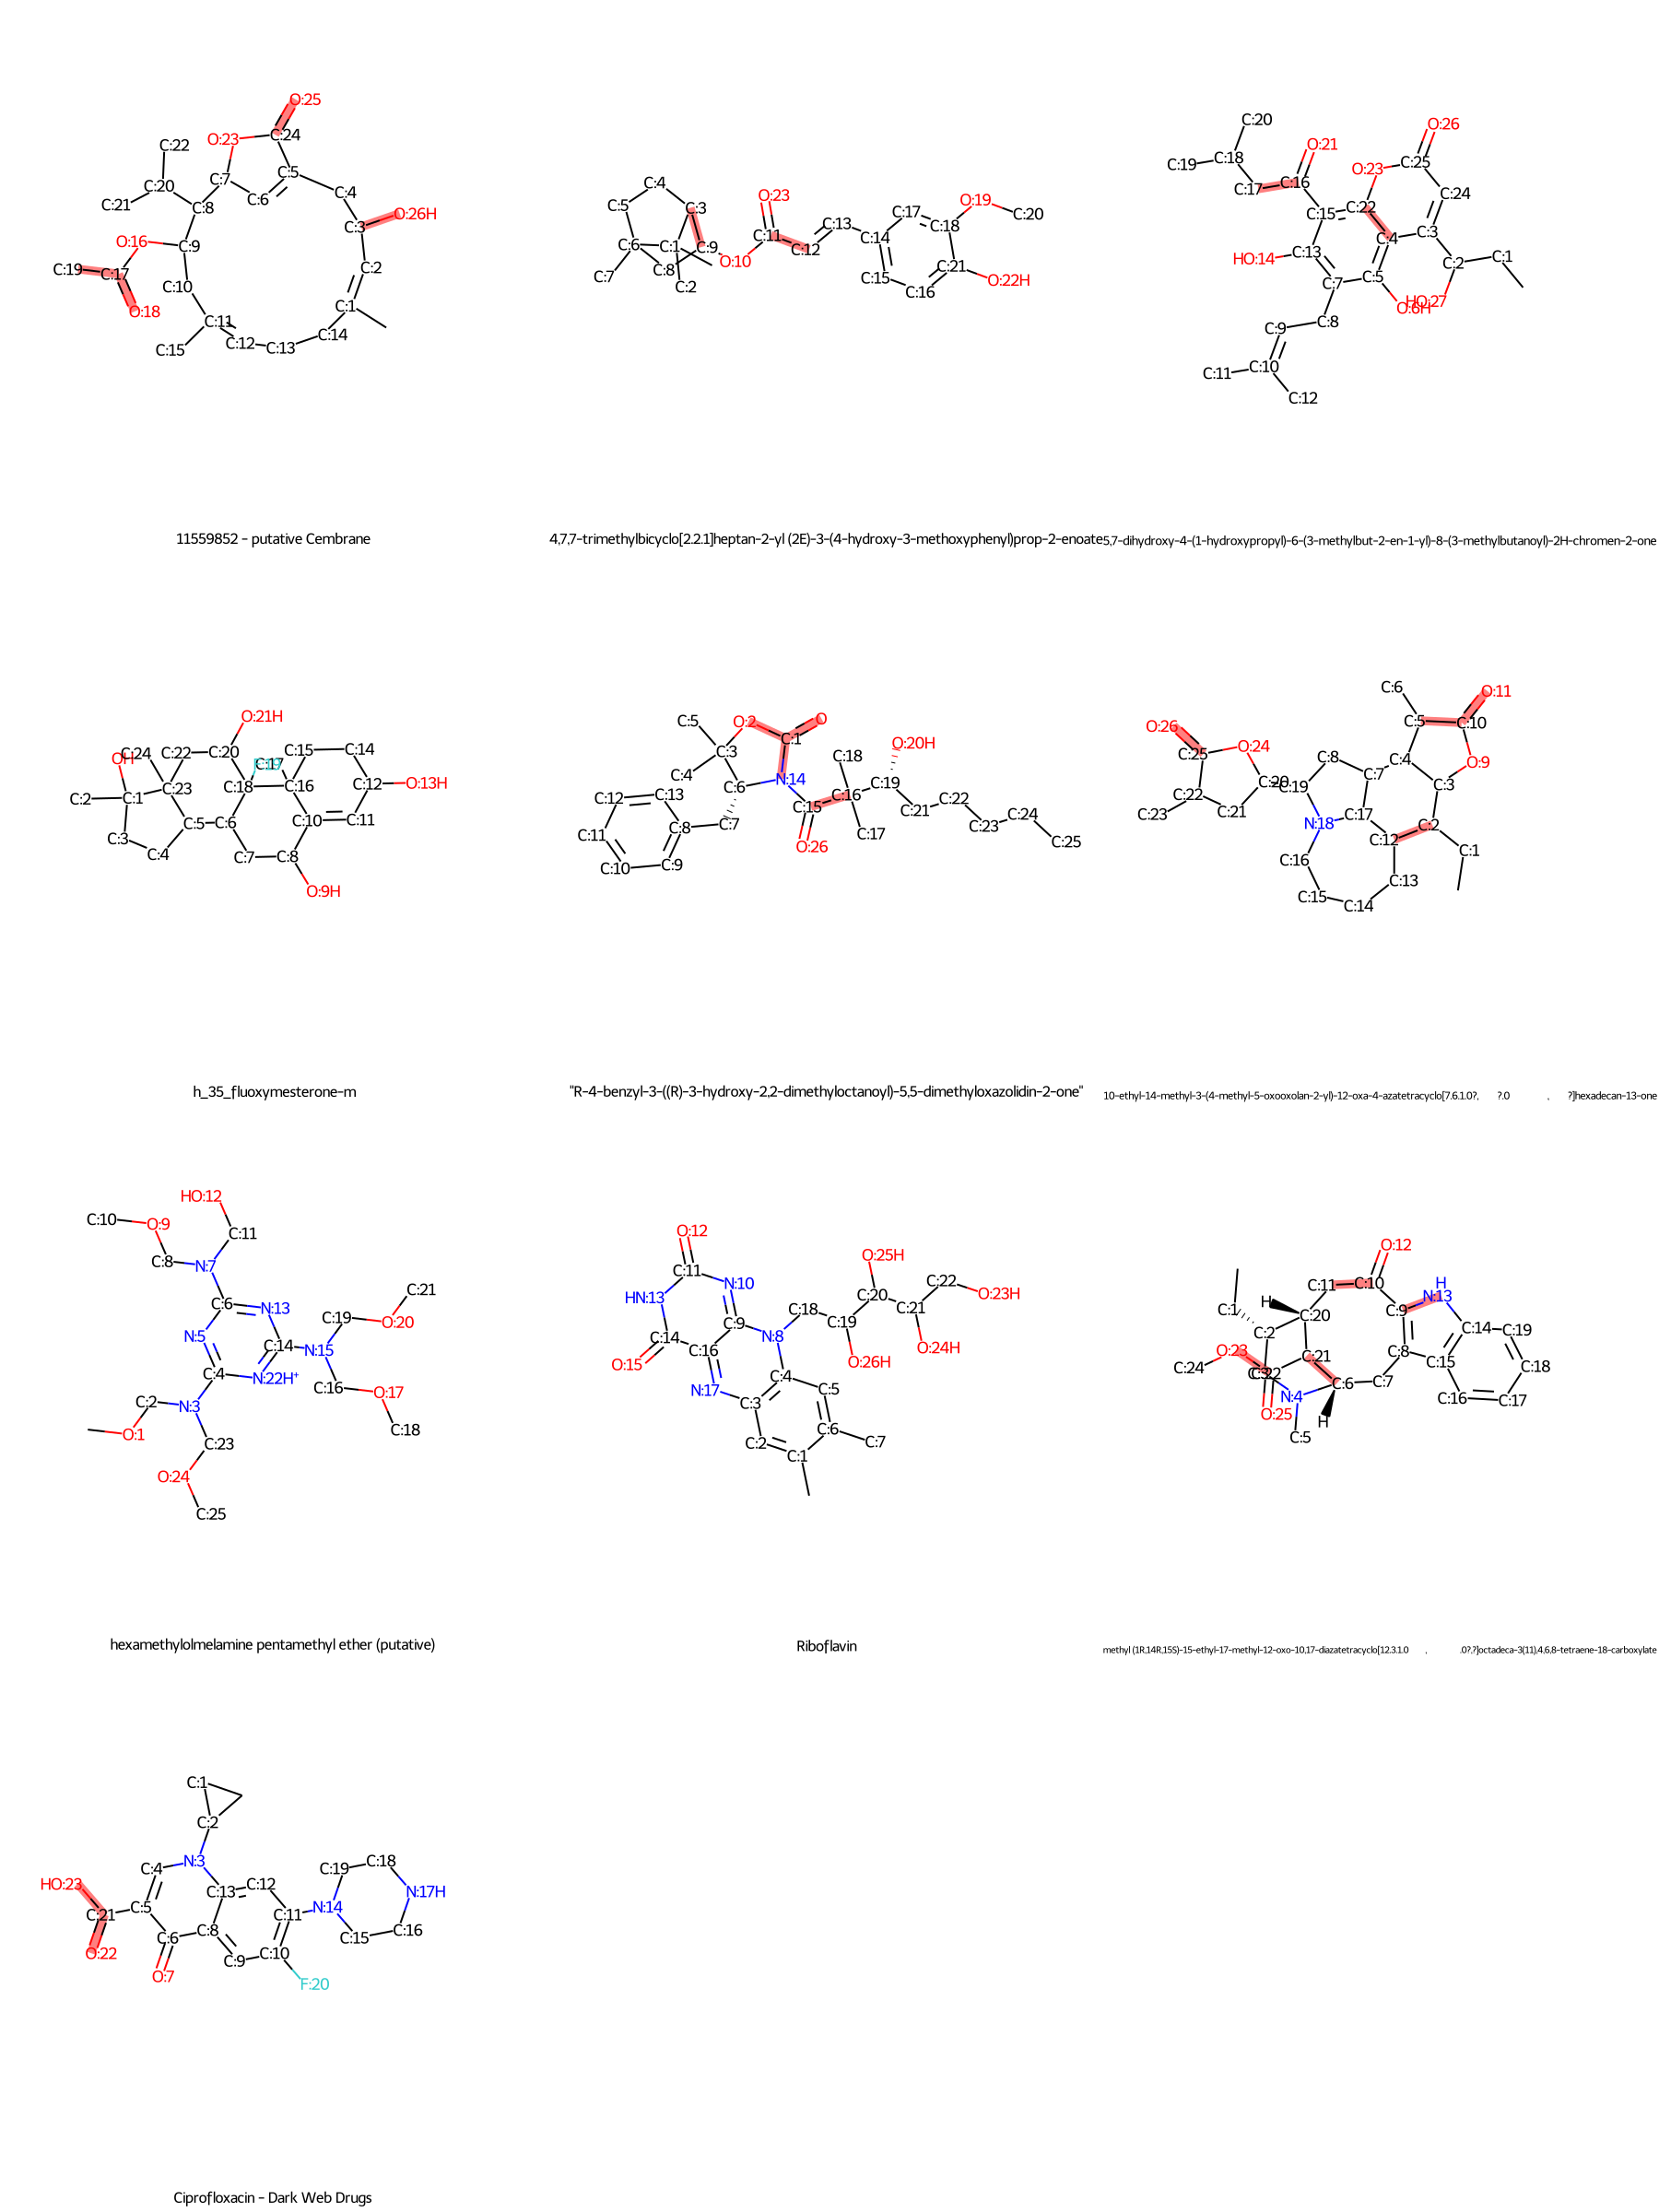

In [8]:
plotter.plot_molecule_structure_grid(spectra_matches[1], draw_indices=True, molecule_image_size=[600, 600], substructure_highlight="C(=O)")

### Creating a Plot using the ClassyFire APIm

<BarContainer object of 9 artists>

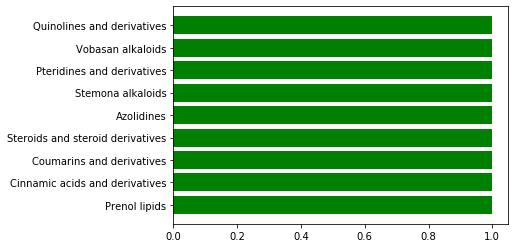

In [9]:
plotter.plot_classyfire_result(spectra_matches[1])

### Creating a Plot using the NP-Classifier API

<BarContainer object of 6 artists>

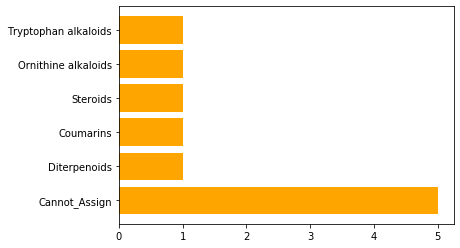

In [10]:
plotter.plot_NPclassifier_result(spectra_matches[1], color='orange')

____